# Analyze DashT data off-line

<img src="img/by-nc.png" alt="Attribution 4.0 International (CC BY 4.0)" width="100"> [Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by-nc/4.0/) 2021-07-10 by [canne](https://github.com/canne)

This paper studies different methods to work off-line with the data stored by [DashT, an OpenCPN chartplotter plug-in](https://dashboard-tactics-pi.readthedocs.io/) in view of analyzing data sets collected in long period of time, like during long legs of an offshore race.

We are studying the way synchronize datasets where the data is coming from various instruments having their own, asynchronous data rate. This error was mentioned in the tutorial  [1_TWA_TWS_STW_from_InfluxDBv2_calc_perf.ipynb](1_TWA_TWS_STW_from_InfluxDBv2_calc_perf.ipynb) addressing a simplified use case of a short regatta leg. It is therefore recommended to study that document first. 

## Using time reference instead of index

When analysing data for a short period of time, say on a single leg of a coastal regatta one can quite safely simply the life and ignore the time domain in the data and use the index of various dataframe columns and compare the dataframes between each other. This is what one is basically doing underway, with a graphical data analysis tool like [Grafana](https://dashboard-tactics-pi.readthedocs.io/en/latest/influxdb/influxdb.html#Grafana). 

But if we want to analyze numerically data which is collected during a long period of time, like in a long offshore leg, let's give this approach a second thought by first looking at the data acquisition method used:

_DastT_ contains Tactics algorithms, which are used to produce many data parameters, like the TWA/TWS used in the example below. As soon as one starts to mix calculated data (which is fast and more or less regular if the CPU-load is low) with the data captured from the boat's databus - the STW data used in the example below - one cannot consider that two data values present their values at the same moment in time.

This is true also for the data which is purely collected from boat's databus since the bus and the data on it is by definition asynchronous, since various instruments and sensors producing data are not synchronized by a clock tick and the bus in general is multimastered, so that the data producers can talk and send their data once they have it available.

>**Underway data plotting** and **Offline data analysis** are two different worlds: When underway, _DashT_'s Tactics algorithms do not suffer from this problem too much since they deal with the incoming data as soon as they arrive, maybe keeping a few tens of items from the past for the exponential smoothing. This happens without consider the the time delay between the two data since only a very limited number of buffered data is used in algorithms. Most of the algorithms are implementing exponential smoothing (_La Viola_) which attenuates all signals to the point that it is not a major concern of having, say two input values of AWA and HDG arriving one second interval between the two.

In off-line analysis of a time series of data we can do better by simply fact that we can observe at any point not only the recent history but also the future (from the observed moment point of view). Or actually, we **have to do better** if there are thousands of data points from various sources. The difference in time of the data points, if purely based on each data set index would introduce errors in the calculations since we would compare TWA/TWS data at one point in time to the STW data which had occurred, actually already earlier in time - there are more STW data points than there is TWA/TWS data: if you loop with index, you are going to deviate from the actual STW value at that moment of time.

In this example we are going to study time based approach to the _DashT_ data analysis.

## Retrieve TWA, TWS and STW from InfluxDB v2.0 and make time based fit

In this example we analyze the data which has been collected in a past event into the InfluxDB v2.0 time series database using DashT database streamer.

We retrieve True Wind data for speed and angle (TWS and TWA) and speed through water data (STW) from the database during a period of interest.

The objective is to extract data from that set of data in a format which would allow us to compare the performance against the currently used polar file, in order to consider can we improve it - or shall we improve our sailing instead...

The secondary objective is to demonstrate how the data within the same time window does not have same index and time correlation but that we have to use the _time_ in time series database to combine the data from different sources.

There are two ways of doing the data combining:

1. Ask all data individually, only reasonably aggregated with original timestamps and then combine the data using the platform's tools and available methods ;
1. Ask all data in one query and let the database and the platform dependent query routine to build the data structure with unique timestamps.

We will study the two methods below before starting the actual combining work.

## Retrieve individual values and align the time base

In order to be able to deal with very large datasets, statistical methods must be used. First, directly on the database server to return a reasonably smoothed signal and later to fit a curve on those dataset points which are already smoothed by the database API functions.

Another method is to make all calculations from the pure raw data but as we can see from the rational presented below there is absolutely nothing to gain in this approach but both the CPU and the development time will be just wasted.

This example is executed on the data imported from a training session in 2018, analyzed in 2021: the timestamps are artificial, created from the GPS data synchronized time. Therefore the effective resolution of the data is in seconds not in milliseconds (albeit millisecond EPOCH timestamps are still used). We will be aiming to that resolution in the synchronization.

I have previously visualized the data on InfluxDB v2.0 web interface explorer and determined that the efficient sail time with a search for performance was from `2018-09-28T08:03:00Z` to `2018-09-28T09:22:00Z` :

>It is good idea to record, while sailing the interesting time period. If you did not remember to it, you can use the InfluxDB's data explorer to find a suitable timeframe region of interest. In this example the Flux query to visualize the TWS data built with InfluxDB 2.0 data explorer user interface is:

```
from(bucket: "nmea")
  |> range(start: 2018-09-28T08:03:00Z, stop: 2018-09-28T09:22:00Z)
  |> filter(fn: (r) => r["_measurement"] == "navigation")
  |> filter(fn: (r) => r["_field"] == "speedThroughWater")
  |> aggregateWindow(every: v.15s, fn: mean, createEmpty: false)
  |> yield(name: "mean")

```

<img src="img/s_2_stw_mean_15s.png"
alt="InfluxDB showing STW in 15s windows fn: mean" width="500">[(zoom)](img/2_stw_mean_15s.png)

The above is convenient for an eye, but we probably want more points. For example, we may want to use statistical analysis later on. Let's take a look with InfluxDB v2.0 how the curve look with no _mean()_ smoothened window chunks, we remove the _aggregateWindow()_ line from the query:

<img src="img/s_2_stw_all_datapoints.png"
alt="InfluxDB showing STW all points, no aggregation functions" width="500">[(zoom)](img/2_stw_all_datapoints.png)

That's a lot of datapoints! But we probably need to apply some type of smoothening, like the one DashT's _Tactics_ algorithms are using, exponential sliding averaging. Why not ask the InfluxDB v2.0 server apply it before returning us the dataset, here for the 20 points at a time:

<img src="img/s_2_stw_exp_movAvg_n20.png"
alt="InfluxDB showing STW, aggregation expopentialMovingAverage()" width="500">[(zoom)](img/2_stw_exp_movAvg_n20.png)

Let's try with a non-exponential moving average, which is probably a bit faster, otherwise the same as above:

<img src="img/s_2_stw_movAvg_n20.png"
alt="InfluxDB showing STW, aggregation movingAverage(n:20)" width="500">[(zoom)](img/2_stw_movAvg_n20.png)

It looks good! It has even less ripple than the exponential version, so let's use _movingAverage()_ to pre-process the values returned for each dataset.

Let's try to increase the n=50

<img src="img/s_2_stw_movAvg_n50.png"
alt="InfluxDB showing STW, aggregation movingAverage(n: 50)" width="500">[(zoom)](img/2_stw_movAvg_n50.png)

## Python example data retrieval

Here we use a simple https://github.com/influxdata/influxdb-client-python#queries method.

This example is executed with Jupyter 2.2.8 and thus with Python 3, making connection to the InfluxDB v2.0 server where the above data is located.

When opened on an external data retrieval system, this `.ipynb` file would not execute but shows only the code:

* There is a PDF-printout of a run of code, with the plots: [2_TWA_TWS_STW_from_InfluxDBv2_collect_data_for_polar.pdf](2_TWA_TWS_STW_from_InfluxDBv2_collect_data_for_polar.pdf)
* The Python code does not require Jupyter - it is used for development and documentation purposes

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('../'))

### Python tools

Needed to install:
```
pip install influxdb_client
pip install matplotlib
pip install numpy
pip install gekko
pip install scipy
```

In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from gekko import GEKKO

The following plotting library used for fancy plots has a name suitable for the subject!

```
pip install seaborn
```

In [3]:
import seaborn as sns

### InfluxDB Client API

In [4]:
from influxdb_client import InfluxDBClient, Point, Dialect
from influxdb_client.client.write_api import SYNCHRONOUS

### InfluxDB Out streamer settings

In [5]:
client = InfluxDBClient(url='http://127.0.0.1:9999', token='4YSbLAg1cWasJqDt6_BSsBsD472SAsRKWgCDN_xZfEDliruk9CgT7lYqk6bvJsIR9PaRHEdsU2nGUGnDOAoO9A==', org='myboat')

### Data range and aggregation

In [6]:
start_time = '2018-09-28T08:03:00Z'
stop_time = '2018-09-28T09:22:00Z'
aggregate_function = 'movingAverage'
aggregate_items = '50'

In [7]:
query_api = client.query_api()

#### Flux True Wind Speed Data

In [8]:
tws_flux = '''
    from(bucket: "nmea")
        |> range
''' +   '(start: ' + start_time + ', stop: ' + stop_time + ')' + '''
        |> filter(fn: (r) => r["_measurement"] == "environment")
        |> filter(fn: (r) => r["_field"] == "wind")
        |> filter(fn: (r) => r["prop1"] == "speedTrueGround")
        |> filter(fn: (r) => r["prop2"] == "tws")
        |> keep(columns: ["_time", "_value"])
        |> 
''' +     aggregate_function + '(n: ' + aggregate_items + ')'

Record format query, this mainly for debugging, thus commented:

In [9]:
# tws_flux

In [10]:
# records = query_api.query_stream( tws_flux )

In [11]:
#i = 1
#for record in records:
#    print(f'{i}: TWS in {record["_time"]} is {record["_value"]}')
#    i = i + 1

For the record, the above example query returns 2873 rows of data for the 79 minutes of window of interest, which equals approximately 36 data rows per minute, and 0.6 samples per second. This corresponds the rate observed on this NMEA-0183 sentence based data acquisition system.

Instead of an array of records above, we retrieve the query in a **Panda DataFrame**:

In [12]:
tws_df = query_api.query_data_frame( tws_flux )

In [13]:
tws_df.head()

,result,table,_time,_value
0,_result,0,2018-09-28 08:04:47.156000+00:00,9.593657
1,_result,0,2018-09-28 08:04:49.137000+00:00,9.577177
2,_result,0,2018-09-28 08:04:50.299000+00:00,9.561069
3,_result,0,2018-09-28 08:04:51.442000+00:00,9.514141
4,_result,0,2018-09-28 08:04:52.458000+00:00,9.463630


In [14]:
tws_df.tail()

,result,table,_time,_value
2868,_result,0,2018-09-28 09:21:04.219000+00:00,9.169290
2869,_result,0,2018-09-28 09:21:06.031000+00:00,9.155120
2870,_result,0,2018-09-28 09:21:07.234000+00:00,9.133253
2871,_result,0,2018-09-28 09:21:08.297000+00:00,9.080272
2872,_result,0,2018-09-28 09:21:09.414000+00:00,9.043691


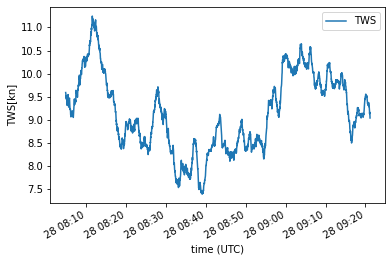

In [15]:
tws_df.plot(x='_time',y='_value', label='TWS')
plt.ylabel('TWS[kn]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()

### Flux True Wind Angle Data

In [16]:
twa_flux = '''
    from(bucket: "nmea")
        |> range
''' +   '(start: ' + start_time + ', stop: ' + stop_time + ')' + '''
        |> filter(fn: (r) => r["_measurement"] == "environment")
        |> filter(fn: (r) => r["_field"] == "wind")
        |> filter(fn: (r) => r["prop1"] == "angleTrue")
        |> keep(columns: ["_time", "_value"])
        |> 
''' +     aggregate_function + '(n: ' + aggregate_items + ')'

In [17]:
twa_df = query_api.query_data_frame( twa_flux )

In [18]:
twa_df.head()

,result,table,_time,_value
0,_result,0,2018-09-28 08:04:47.156000+00:00,87.712212
1,_result,0,2018-09-28 08:04:49.137000+00:00,87.598977
2,_result,0,2018-09-28 08:04:50.299000+00:00,87.767316
3,_result,0,2018-09-28 08:04:51.442000+00:00,87.927717
4,_result,0,2018-09-28 08:04:52.458000+00:00,87.609268


In [19]:
twa_df.tail()

,result,table,_time,_value
2868,_result,0,2018-09-28 09:21:04.219000+00:00,106.388855
2869,_result,0,2018-09-28 09:21:06.031000+00:00,106.425194
2870,_result,0,2018-09-28 09:21:07.234000+00:00,106.142250
2871,_result,0,2018-09-28 09:21:08.297000+00:00,105.700211
2872,_result,0,2018-09-28 09:21:09.414000+00:00,105.475321


So far, so good for those who want or need to do only index based calculations and ignore the time aspect. The TWA and TWS are calculated values, provided by the _DashT_ Tactics algorithms. Their values are generated at the same time at the arrival of other wind data, such as AWA and/or AWS. Therefore the timestamps remains close to each other and the number of samples remain the same.

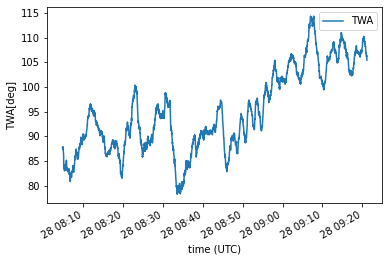

In [20]:
twa_df.plot(x='_time',y='_value', label='TWA')
plt.ylabel('TWA[deg]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()

### Flux Speed through the water

In [21]:
stw_flux = '''
    from(bucket: "nmea")
        |> range
''' +   '(start: ' + start_time + ', stop: ' + stop_time + ')' + '''
        |> filter(fn: (r) => r["_measurement"] == "navigation")
        |> filter(fn: (r) => r["_field"] == "speedThroughWater")
        |> keep(columns: ["_time", "_value"])
        |> 
''' +     aggregate_function + '(n: ' + aggregate_items + ')'

In [22]:
stw_df = query_api.query_data_frame( stw_flux )

In [23]:
stw_df.head()

,result,table,_time,_value
0,_result,0,2018-09-28 08:04:47.186000+00:00,4.9568
1,_result,0,2018-09-28 08:04:49.168000+00:00,4.9784
2,_result,0,2018-09-28 08:04:50.331000+00:00,4.9972
3,_result,0,2018-09-28 08:04:52.061000+00:00,5.0162
4,_result,0,2018-09-28 08:04:54.200000+00:00,5.0192


In [24]:
stw_df.tail(20)

,result,table,_time,_value
2869,_result,0,2018-09-28 09:20:37.140000+00:00,4.1352
2870,_result,0,2018-09-28 09:20:40.015000+00:00,4.1164
2871,_result,0,2018-09-28 09:20:41.313000+00:00,4.1034
2872,_result,0,2018-09-28 09:20:43.422000+00:00,4.1076
2873,_result,0,2018-09-28 09:20:45.109000+00:00,4.0860
2874,_result,0,2018-09-28 09:20:46.250000+00:00,4.0824
2875,_result,0,2018-09-28 09:20:49.141000+00:00,4.0682
2876,_result,0,2018-09-28 09:20:51.110000+00:00,4.0660
2877,_result,0,2018-09-28 09:20:52.187000+00:00,4.0540
2878,_result,0,2018-09-28 09:20:53.344000+00:00,4.0516


We can observe that for STW we have 15 samples more than for the TWA and TWS, which have 2873 samples. The time shift in the end of STW compared to other two is 26 seconds, if we compare the time in STW sample number 2872 to the TWA and TWS counterparts.

Even it it not that much on the water, it would be more significant if we would have recorded data, say for a few more hours. Anyway, 26 seconds shift in a dataset is as a good reason to use the timestamps as reference and not the index of the dataset. Let's plot the STW data:

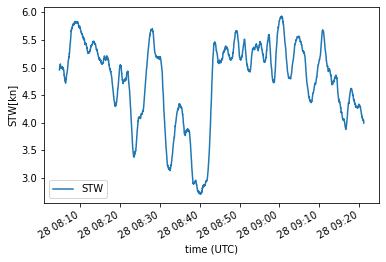

In [25]:
stw_df.plot(x='_time',y='_value', label='STW')
plt.ylabel('STW[kn]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()

### Flux Heading True

To further demonstrate the need of the time based analysis instead of index based strolling through the data, let's take a look at the True Heading data collected during the same period (this is given by the boat's databus):

In [26]:
hdg_flux = '''
    from(bucket: "nmea")
        |> range
''' +   '(start: ' + start_time + ', stop: ' + stop_time + ')' + '''
        |> filter(fn: (r) => r["_measurement"] == "navigation")
        |> filter(fn: (r) => r["_field"] == "headingTrue")
        |> keep(columns: ["_time", "_value"])
        |> 
''' +     aggregate_function + '(n: ' + aggregate_items + ')'

In [27]:
hdg_df = query_api.query_data_frame( hdg_flux )

In [28]:
hdg_df.head()

,result,table,_time,_value
0,_result,0,2018-09-28 08:04:30.280000+00:00,69.06
1,_result,0,2018-09-28 08:04:31.437000+00:00,69.10
2,_result,0,2018-09-28 08:04:33.235000+00:00,69.10
3,_result,0,2018-09-28 08:04:34.235000+00:00,69.12
4,_result,0,2018-09-28 08:04:35.297000+00:00,69.10


In [29]:
hdg_df.tail()

,result,table,_time,_value
3410,_result,0,2018-09-28 09:21:04.281000+00:00,49.14
3411,_result,0,2018-09-28 09:21:06.141000+00:00,49.09
3412,_result,0,2018-09-28 09:21:07.328000+00:00,49.05
3413,_result,0,2018-09-28 09:21:09.047000+00:00,49.00
3414,_result,0,2018-09-28 09:21:10.140000+00:00,48.98


It goes without saying that the number of samples being much larger than the TWA/TWS or even STW it is necessary to use time based analysis with this data, not sample index based.

### Flux - Can I get them all?

This section demonstrates the effect of requesting all data at one go, _i.e._ not only making the smoothing of a signal using the database's algorithms for it but also requesting it to provide unified timestamps for the smoothed data.

In [30]:
all_flux = '''
    from(bucket: "nmea")
        |> range
''' +   '(start: ' + start_time + ', stop: ' + stop_time + ')' + '''
        |> filter(fn: (r) =>
           r["_measurement"] == "navigation" or
           r["_measurement"] == "environment")
        |> filter(fn: (r) =>
           (r["_field"] == "wind" and
           (r["prop1"] == "speedTrueGround" or r["prop1"] == "angleTrue")) or
           r["_field"] == "speedThroughWater")
        |> drop(columns: ["_start", "_stop"])
        |> 
''' +     aggregate_function + '(n: ' + aggregate_items + ')'

In [31]:
all_df = query_api.query_data_frame( all_flux )

In [32]:
print( all_df )

[       result table                            _time  _value  \
0     _result     0 2018-09-28 08:04:47.186000+00:00  4.9568   
1     _result     0 2018-09-28 08:04:49.168000+00:00  4.9784   
2     _result     0 2018-09-28 08:04:50.331000+00:00  4.9972   
3     _result     0 2018-09-28 08:04:52.061000+00:00  5.0162   
4     _result     0 2018-09-28 08:04:54.200000+00:00  5.0192   
...       ...   ...                              ...     ...   
2884  _result     0 2018-09-28 09:21:03.016000+00:00  4.0518   
2885  _result     0 2018-09-28 09:21:04.016000+00:00  4.0270   
2886  _result     0 2018-09-28 09:21:06.188000+00:00  4.0330   
2887  _result     0 2018-09-28 09:21:08.047000+00:00  4.0162   
2888  _result     0 2018-09-28 09:21:09.094000+00:00  3.9908   

                 _field _measurement  
0     speedThroughWater   navigation  
1     speedThroughWater   navigation  
2     speedThroughWater   navigation  
3     speedThroughWater   navigation  
4     speedThroughWater   navigatio

The test demonstrates that t is possible to create a complex, and actually quite well performing query thanks to _DashT_ database schema, the returning data format reveals the following information:

1. The data is not in a single Pandas DataFrame but in multiple tables ;
1. Tables have different number of items - just like the individual queries ;
1. The data timestamps are not unified (see above) - there is no "time smoothing" or synchronization but original timestamps are retained as expected.

Albeit it is technically possible to make a single query, it does not make sense to save time in the query alone, unless one plans some underway application which should show data in real time and query performance has its importance. But then Python script and Pandas are not probably the right tool in the case the complex data structure which results still needs to be decomposed and restructured in quasi-real time. For off-line analysis and for graphical on-line analysis it is totally justified to make the inquiry of individual simple tables, synchronize them and build from them a 2D Pandas DataFrame without adding an extra step to this process.

### Close database streaming connection

In [33]:
client.close()

## Fitting curve methods

In this section we study different curve fitting methods on above datasets in order to select the one for the implementation.

### Gekko 

We study the usage of  `gekko` Python package for machine learning and optimization, specializing in time series https://github.com/BYU-PRISM/GEKKO - see also http://apmonitor.com/wiki/index.php/Main/GekkoPythonOptimization for learning. Documentation: https://gekko.readthedocs.io/en/latest/index.html

##### STW Gekko spline()

We use a remote problem resolver (see http://apmonitor.com), so one needs a network connection. 

In [34]:
m = GEKKO(remote=True)

convert Panda DataFrame colums to Numpy array(s):

In [35]:
stw_df.columns

Index(['result', 'table', '_time', '_value'], dtype='object')

In [36]:
stw_datetime = pd.to_datetime(stw_df['_time'], unit='ms')

In [37]:
stw_datetime.describe

<bound method NDFrame.describe of 0      2018-09-28 08:04:47.186000+00:00
1      2018-09-28 08:04:49.168000+00:00
2      2018-09-28 08:04:50.331000+00:00
3      2018-09-28 08:04:52.061000+00:00
4      2018-09-28 08:04:54.200000+00:00
                     ...               
2884   2018-09-28 09:21:03.016000+00:00
2885   2018-09-28 09:21:04.016000+00:00
2886   2018-09-28 09:21:06.188000+00:00
2887   2018-09-28 09:21:08.047000+00:00
2888   2018-09-28 09:21:09.094000+00:00
Name: _time, Length: 2889, dtype: datetime64[ns, tzutc()]>

Convert DateTime to numerical (Epoch) value in _s_

In [38]:
stw_time_int64 = stw_datetime.astype(np.int64).div(1e9)

In [39]:
stw_time_int64.describe

<bound method NDFrame.describe of 0       1.538122e+09
1       1.538122e+09
2       1.538122e+09
3       1.538122e+09
4       1.538122e+09
            ...     
2884    1.538126e+09
2885    1.538126e+09
2886    1.538126e+09
2887    1.538126e+09
2888    1.538126e+09
Name: _time, Length: 2889, dtype: float64>

Scale down so that x-origin (Epoch) would be in zero

In [40]:
stw_time_int64[0]

1538121887.1859999

In [41]:
stw_time_int64 = stw_time_int64.sub(stw_time_int64[0])

In [42]:
stw_time_int64.describe

<bound method NDFrame.describe of 0          0.000
1          1.982
2          3.145
3          4.875
4          7.014
          ...   
2884    4575.830
2885    4576.830
2886    4579.002
2887    4580.861
2888    4581.908
Name: _time, Length: 2889, dtype: float64>

In [43]:
stw_time_value = stw_time_int64.to_numpy()

In [44]:
stw_time_value

array([0.00000000e+00, 1.98200011e+00, 3.14500022e+00, ...,
       4.57900200e+03, 4.58086100e+03, 4.58190800e+03])

In [45]:
stw_value = stw_df['_value'].to_numpy()

In [46]:
stw_value

array([4.9568, 4.9784, 4.9972, ..., 4.033 , 4.0162, 3.9908])

In [47]:
stw_time_short = stw_time_value[:10]

In [48]:
stw_time_short

array([ 0.        ,  1.98200011,  3.14500022,  4.875     ,  7.01400018,
        8.19400024, 10.03800011, 11.82900023, 13.11600018, 14.16799998])

In [49]:
stw_value_short = stw_value[:10]

In [50]:
stw_value_short

array([4.9568, 4.9784, 4.9972, 5.0162, 5.0192, 5.0154, 5.0278, 5.04  ,
       5.0472, 5.064 ])

In [51]:
# define Spline function
m.x = m.Param(value=np.linspace(-1,15))
m.y = m.Var()
m.options.IMODE=2
m.cspline(m.x,m.y,stw_time_short,stw_value_short)
m.solve(disp=False)

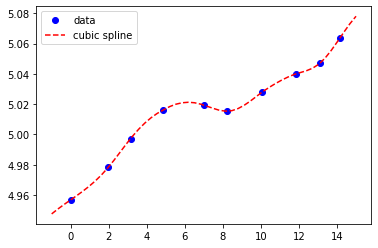

In [52]:
plt.plot(stw_time_short,stw_value_short,'bo',label='data')
plt.plot(m.x.value,m.y.value,'r--',label='cubic spline')
plt.legend(loc='best')
plt.show()

Looks great! We probably do not want to read a plot, though. How to get a value of y when the `y` is known?

In [53]:
p = GEKKO(remote=True)

In [54]:
p.x = p.Param(value=4)
p.y = p.Var()
p.options.IMODE=3
p.cspline(p.x,p.y,stw_time_short,stw_value_short)
p.Obj(-p.y)
p.solve(disp=False)

In [55]:
p.y

[5.0086814804]

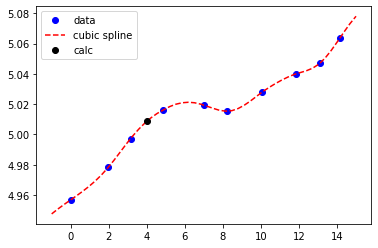

In [56]:
plt.plot(stw_time_short,stw_value_short,'bo',label='data')
plt.plot(m.x.value,m.y.value,'r--',label='cubic spline')
plt.plot(p.x.value,p.y.value,'ko',label='calc')
plt.legend(loc='best')
plt.show()

Let's see how we can get values from spline function, say every second? Note that you have to set the `IMODE=2` to get an array back, see https://gekko.readthedocs.io/en/latest/imode.html#mpu. Above, where we are looking for a single value, `IMODE=3`, see https://gekko.readthedocs.io/en/latest/imode.html#rto (default).

In [57]:
xtime_points = np.array([1,2,3,4,5,6,7,8,9,10])

In [58]:
p.x = p.Param(xtime_points)
p.y = p.Var()
p.options.IMODE=2
p.cspline(p.x,p.y,stw_time_short,stw_value_short)
p.Obj(-p.y)
p.solve(disp=False)

In [59]:
p.y

[4.9660868097, 4.9786656322, 4.9949298527, 5.0086814804, 5.0171099676, 5.0211515941, 5.0192695202, 5.0155248562, 5.0183811716, 5.0274301564]

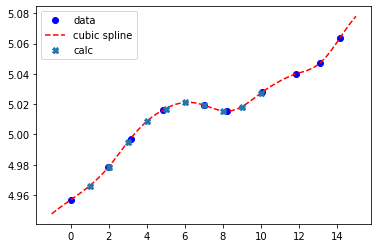

In [60]:
plt.plot(stw_time_short,stw_value_short,'bo',label='data')
plt.plot(m.x.value,m.y.value,'r--',label='cubic spline')
plt.plot(p.x.value,p.y.value,'X',label='calc')
plt.legend(loc='best')
plt.show()

Ok, let's try now with a bit more points (we try 100, 500 and then all data points which is shown below)

In [61]:
stw_time_short = stw_time_value[:-1]

In [62]:
stw_value_short = stw_value[:-1]

In [63]:
m.x = m.Param(value=np.linspace(-1,1.558*stw_time_short.size))
m.y = m.Var()
m.options.IMODE=2
m.cspline(m.x,m.y,stw_time_short,stw_value_short)
m.solve(disp=False)

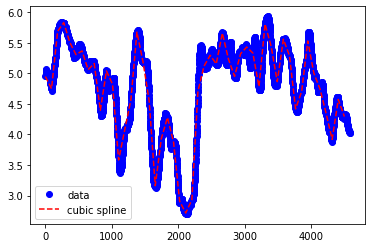

In [64]:
plt.plot(stw_time_short,stw_value_short,'bo',label='data')
plt.plot(m.x.value,m.y.value,'r--',label='cubic spline')
plt.legend(loc='best')
plt.show()

This is pretty good estimation of the STW, taking away the noise. The sole problem I see is that coefficient above (`1.558`) which is purely experimental: with `1.6` there is an overshoot, otherwise there is always an undershoot, which cannot be completely eliminated. One need to stop the analysis a little bit before the time scale end (at 4000 seconds).

>**NOTE**: The STW data is coming from a paddle wheel (in this case, and quite usually). If you have ever a possibility to drive with a motor on very calm waters with little or no current and you record the STW data it will be surprisingly ripple free. The noise in the sailing conditions like above are coming from the turbulent water flow in addition to the waves and other changes in the relative water speed.

Second problem is that we do not have enough data points: as defined above, there seems to be an issue if the number of values given are getting larger. Let's see what is the current x-axis values:

In [65]:
m.x

[-1.0, 90.847020408, 182.69404082, 274.54106122, 366.38808163, 458.23510204, 550.08212245, 641.92914286, 733.77616327, 825.62318367, 917.47020408, 1009.3172245, 1101.1642449, 1193.0112653, 1284.8582857, 1376.7053061, 1468.5523265, 1560.3993469, 1652.2463673, 1744.0933878, 1835.9404082, 1927.7874286, 2019.634449, 2111.4814694, 2203.3284898, 2295.1755102, 2387.0225306, 2478.869551, 2570.7165714, 2662.5635918, 2754.4106122, 2846.2576327, 2938.1046531, 3029.9516735, 3121.7986939, 3213.6457143, 3305.4927347, 3397.3397551, 3489.1867755, 3581.0337959, 3672.8808163, 3764.7278367, 3856.5748571, 3948.4218776, 4040.268898, 4132.1159184, 4223.9629388, 4315.8099592, 4407.6569796, 4499.504]

Not that many points, and not arranged regularly. Let's try with NumPy.arange() function to see which are the limits for the number of points in x-axis: (-1,202,1) ; (-1,502,1):OK/FAIL ; (-1,1002,1):FAIL

In [66]:
p.x = p.Param(np.arange(-1,202,1))
p.y = p.Var()
p.options.IMODE=2
p.cspline(p.x,p.y,stw_time_short,stw_value_short)
p.Obj(-p.y)
p.solve(disp=False)

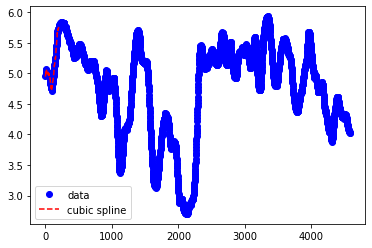

In [67]:
plt.plot(stw_time_short,stw_value_short,'bo',label='data')
plt.plot(p.x.value,p.y.value,'r--',label='cubic spline')
plt.legend(loc='best')
plt.show()

Not enough points can be obtained if resolution is set back to one second!

#### Conclusion on Gekko spline method

The GEKKO library has _modes_ which are difficult to understand, the same library behaves differently in different modes. I think that modes are bad for any library. Anyway, this library is addressing clearly a different usage than this, a quite simple one we are looking for. The service is server based, local or remote. It is certainly an advantage for large scale statistical calculations to have a remote, optimized server. But for some reason, I cannot give it around 2000 - 3000 points and give me a one second interval points (4000 points). Only about 200 points maximum are possible, I found. Maybe some server parameter, the settings are quite complicated, so I give up for now. 

### Pandas DataFrame / SciPy solution

We use the [pandas.DataFrame.interpolate()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html): the plan is simple:

1. Create a new dataframe where one has full second values with NaN + the collected data
1. Interpolate the data points with NaN using SciPy signal spline function

#### STW DataFrame modification

Ok, this is going to be a bit slow (for a Pandas DataFrames which are vectorized and thus can be faster) since we are going to loop throug each dataset. There is certainly a better way to do it, like writing some [C-extensions for Python](https://cython.org) like somebody is boasting in [this discussion of Stackoverflow](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas) - but that's a bit overkilling since here we have time and we just want to test the interpolate methods.

We use copy of one Pandas DataFrame items to another, knowing what we do but this creates warning in Python. See this [discussion in Stackoverflow](https://stackoverflow.com/questions/47182183/pandas-chained-assignment-warning-exception-handling). For now we ignore the warning.

In [68]:
pd.options.mode.chained_assignment = None

In [69]:
stw_df.columns

Index(['result', 'table', '_time', '_value'], dtype='object')

In [70]:
s_columns = ['_time','_value','floored']

In [71]:
stw_prev_s = stw_df['_time'][0].floor(freq='S')

In [72]:
stw_prev_s

Timestamp('2018-09-28 08:04:47+0000', tz='tzutc()')

In [73]:
stw_df_s_filler = pd.DataFrame([[stw_prev_s, np.nan, True]], columns = s_columns)

In [74]:
stw_df_s_filler

,_time,_value,floored
0,2018-09-28 08:04:47+00:00,NaN,True


In [75]:
stw_df_s_filler.axes

[RangeIndex(start=0, stop=1, step=1),
 Index(['_time', '_value', 'floored'], dtype='object')]

In [76]:
stw_df_s_filler.is_copy = False

In [77]:
print (stw_df_s_filler)

                      _time  _value  floored
0 2018-09-28 08:04:47+00:00     NaN     True


In [78]:
stw_df_s_filled = pd.DataFrame( [[stw_df_s_filler['_time'][0],stw_df_s_filler['_value'][0], \
                                True]], columns = s_columns)

In [79]:
stw_df_s_filled

,_time,_value,floored
0,2018-09-28 08:04:47+00:00,NaN,True


In [80]:
stw_df_s_filled.is_copy = False

In [81]:
s_delta = pd.Timedelta(1,unit='seconds')

In [82]:
s_delta

Timedelta('0 days 00:00:01')

In [83]:
stw_next_s = stw_prev_s + s_delta

In [84]:
stw_next_s

Timestamp('2018-09-28 08:04:48+0000', tz='tzutc()')

In [85]:
s_InjectMax = 0

In [86]:
stw_df.is_copy = False
for index, row in stw_df.iterrows():
    # print(row['_time'], row['_value'])
    if row['_time'] >= stw_prev_s:
        stw_prev_s_next = row['_time'].floor(freq='S')
        now_Injecting = 0
        while stw_prev_s_next >= stw_next_s:
            stw_df_s_filler['_time'][0]   = stw_next_s
            stw_df_s_filler['_value'][0]  = np.nan
            stw_df_s_filler['floored'][0] = True
            stw_df_s_filled = stw_df_s_filled.append(stw_df_s_filler,True)
            stw_next_s = stw_next_s + s_delta
            now_Injecting = now_Injecting + 1
        stw_next_s = stw_next_s - s_delta
        if now_Injecting > s_InjectMax:
            s_InjectMax = now_Injecting
    stw_df_s_filler['_time'][0]   = row['_time']
    stw_df_s_filler['_value'][0]  = row['_value']
    stw_df_s_filler['floored'][0] = False
    stw_df_s_filled = stw_df_s_filled.append(stw_df_s_filler, True)
    stw_next_s = stw_next_s + s_delta
# This we are going to keep for the interpolation
print('s_InjectMax:', s_InjectMax)

s_InjectMax: 5


In [87]:
stw_df_s_filled.head(20)

,_time,_value,floored
0,2018-09-28 08:04:47+00:00,NaN,True
1,2018-09-28 08:04:47.186000+00:00,4.9568,False
2,2018-09-28 08:04:48+00:00,NaN,True
3,2018-09-28 08:04:49+00:00,NaN,True
4,2018-09-28 08:04:49.168000+00:00,4.9784,False
5,2018-09-28 08:04:50+00:00,NaN,True
6,2018-09-28 08:04:50.331000+00:00,4.9972,False
7,2018-09-28 08:04:51+00:00,NaN,True
8,2018-09-28 08:04:52+00:00,NaN,True
9,2018-09-28 08:04:52.061000+00:00,5.0162,False


In [88]:
stw_df_s_filled.tail(20)

,_time,_value,floored
7452,2018-09-28 09:20:58+00:00,NaN,True
7453,2018-09-28 09:20:58.078000+00:00,4.0522,False
7454,2018-09-28 09:20:59+00:00,NaN,True
7455,2018-09-28 09:21:00+00:00,NaN,True
7456,2018-09-28 09:21:00.015000+00:00,4.0602,False
7457,2018-09-28 09:21:01+00:00,NaN,True
7458,2018-09-28 09:21:01.031000+00:00,4.0564,False
7459,2018-09-28 09:21:02+00:00,NaN,True
7460,2018-09-28 09:21:03+00:00,NaN,True
7461,2018-09-28 09:21:03.016000+00:00,4.0518,False


#### STW Pandas interpolation

Now we have a quite "flat structure" dataframe which has NaN aues on those items which have an injected floored second value. We know also the maximum number of sequence of those NaN values (there was a hole in the data for a few seconds), by `s_InjectMax`. Now we can try go give a value to those NaN values by fitting a best curve on the valid data:

In [89]:
stw_df_s_filled['_value'].interpolate(method='cubic', order=2, \
                                      inplace=True, limit_direction='both')

In [90]:
print(stw_df_s_filled)

                                _time    _value  floored
0           2018-09-28 08:04:47+00:00       NaN     True
1    2018-09-28 08:04:47.186000+00:00  4.956800    False
2           2018-09-28 08:04:48+00:00  4.961812     True
3           2018-09-28 08:04:49+00:00  4.969339     True
4    2018-09-28 08:04:49.168000+00:00  4.978400    False
...                               ...       ...      ...
7467        2018-09-28 09:21:07+00:00  4.031996     True
7468        2018-09-28 09:21:08+00:00  4.025957     True
7469 2018-09-28 09:21:08.047000+00:00  4.016200    False
7470        2018-09-28 09:21:09+00:00  4.004042     True
7471 2018-09-28 09:21:09.094000+00:00  3.990800    False

[7472 rows x 3 columns]


The NaN values in floored seconds have been filled with interpolated data points. Let's make a copy of the dataframe but only for values which have been floored. We use similar dirty trick looping by rows as before.

In [91]:
s_columns = ['_time','_value']

In [92]:
stw_df_s_filler = pd.DataFrame([[stw_prev_s, np.nan]], columns = s_columns)

In [93]:
stw_df_s_filler.is_copy = False

In [94]:
stw_df_s = pd.DataFrame( [], columns = s_columns)

In [95]:
stw_df_s

,_time,_value


In [96]:
stw_df_s.is_copy = False

In [97]:
for index, row in stw_df_s_filled.iterrows():
    # print(row['_time'], row['_value'])
    if row['floored'] and not np.isnan(row['_value']):
        stw_df_s_filler['_time'][0]   = row['_time']
        stw_df_s_filler['_value'][0]  = row['_value']
        stw_df_s = stw_df_s.append(stw_df_s_filler, True)

In [98]:
print(stw_df_s)

                         _time    _value
0    2018-09-28 08:04:48+00:00  4.961812
1    2018-09-28 08:04:49+00:00  4.969339
2    2018-09-28 08:04:50+00:00  4.988014
3    2018-09-28 08:04:51+00:00  5.005118
4    2018-09-28 08:04:52+00:00  5.011495
...                        ...       ...
4577 2018-09-28 09:21:05+00:00  4.024819
4578 2018-09-28 09:21:06+00:00  4.028925
4579 2018-09-28 09:21:07+00:00  4.031996
4580 2018-09-28 09:21:08+00:00  4.025957
4581 2018-09-28 09:21:09+00:00  4.004042

[4582 rows x 2 columns]


Let's compare the original STW curve smoothened by InfluxDB v2.0 at our request at retrieval of the data and the cubic spline estimation of SciPy.signal on it data values, stripped from the original values from the database:

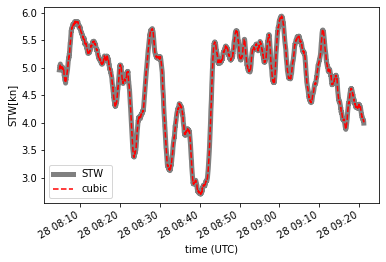

In [99]:
axes = stw_df.plot(x='_time',y='_value', label='STW', color='grey', linewidth=5)
stw_df_s.plot(ax=axes, x='_time',y='_value', label='cubic', color='red', linestyle='--')
plt.ylabel('STW[kn]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()

This is pretty good! In fact, we do not need the originals anymore and we can compare the values with other values.

#### Make interpolation subroutine

The below is an adaptation of the above study, _i.e._ not optimized for performance but good enough.

In [100]:
def interpolateEachSecond( df ) :
    pd.options.mode.chained_assignment = None
    df.is_copy = False
    s_columns = ['_time','_value','floored']
    cnv_prev_s = df['_time'][0].floor(freq='S')
    cnv_df_s_filler = pd.DataFrame([[cnv_prev_s, np.nan, True]], columns = s_columns)
    cnv_df_s_filler.is_copy = False
    cnv_df_s_filled = pd.DataFrame( [[cnv_df_s_filler['_time'][0], \
                                      cnv_df_s_filler['_value'][0], \
                                    True]], columns = s_columns)
    cnv_df_s_filled.is_copy = False
    s_delta = pd.Timedelta(1,unit='seconds')
    cnv_next_s = cnv_prev_s + s_delta
    s_InjectMax = 0
    for index, row in df.iterrows():
        if row['_time'] >= cnv_prev_s:
            cnv_prev_s_next = row['_time'].floor(freq='S')
            now_Injecting = 0
            while cnv_prev_s_next >= cnv_next_s:
                cnv_df_s_filler['_time'][0]   = cnv_next_s
                cnv_df_s_filler['_value'][0]  = np.nan
                cnv_df_s_filler['floored'][0] = True
                cnv_df_s_filled = cnv_df_s_filled.append(cnv_df_s_filler,True)
                cnv_next_s = cnv_next_s + s_delta
                now_Injecting = now_Injecting + 1
            cnv_next_s = cnv_next_s - s_delta
            if now_Injecting > s_InjectMax:
                s_InjectMax = now_Injecting
        cnv_df_s_filler['_time'][0]   = row['_time']
        cnv_df_s_filler['_value'][0]  = row['_value']
        cnv_df_s_filler['floored'][0] = False
        cnv_df_s_filled = cnv_df_s_filled.append(cnv_df_s_filler, True)
        cnv_next_s = cnv_next_s + s_delta
    cnv_df_s_filled['_value'].interpolate(method='cubic', order=2, \
                                          inplace=True, limit_direction='both')
    s_columns = ['_time','_value']
    cnv_df_s_filler = pd.DataFrame([[cnv_prev_s, np.nan]], columns = s_columns)
    cnv_df_s_filler.is_copy = False
    cnv_df_s = pd.DataFrame( [], columns = s_columns)
    cnv_df_s.is_copy = False
    for index, row in cnv_df_s_filled.iterrows():
        if row['floored'] and not np.isnan(row['_value']):
            cnv_df_s_filler['_time'][0]   = row['_time']
            cnv_df_s_filler['_value'][0]  = row['_value']
            cnv_df_s = cnv_df_s.append(cnv_df_s_filler, True)
    cnv_df_s_filled['_value'].interpolate(method='cubic', order=2, \
                                          inplace=True, limit_direction='both')
    s_columns = ['_time','_value']
    cnv_df_s_filler = pd.DataFrame([[cnv_prev_s, np.nan]], columns = s_columns)
    cnv_df_s_filler.is_copy = False
    cnv_df_s = pd.DataFrame( [], columns = s_columns)
    cnv_df_s.is_copy = False
    for index, row in cnv_df_s_filled.iterrows():
        if row['floored'] and not np.isnan(row['_value']):
            cnv_df_s_filler['_time'][0]   = row['_time']
            cnv_df_s_filler['_value'][0]  = row['_value']
            cnv_df_s = cnv_df_s.append(cnv_df_s_filler, True)
    return cnv_df_s

##### Test interpolation routine with STW

In [101]:
test_df_s = interpolateEachSecond( stw_df )

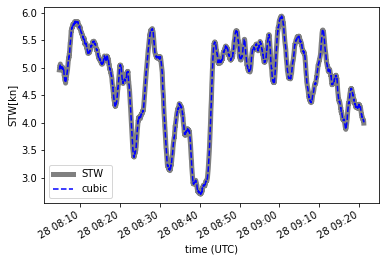

In [102]:
axes = stw_df.plot(x='_time',y='_value', label='STW', color='grey', linewidth=5)
test_df_s.plot(ax=axes, x='_time',y='_value', label='cubic', color='blue', linestyle='--')
plt.ylabel('STW[kn]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()

Looks alright! Now let's interpolate the TWA/TWS data as well:

#### Interpolate TWS data

In [103]:
tws_df_s = interpolateEachSecond( tws_df )

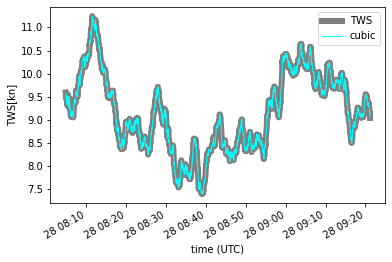

In [104]:
axes = tws_df.plot(x='_time',y='_value', label='TWS', color='grey', linewidth=6)
tws_df_s.plot(ax=axes, x='_time',y='_value', label='cubic', color='cyan', linewidth=1 )
plt.ylabel('TWS[kn]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()

#### Interpolate TWA data

In [105]:
twa_df_s = interpolateEachSecond( twa_df )

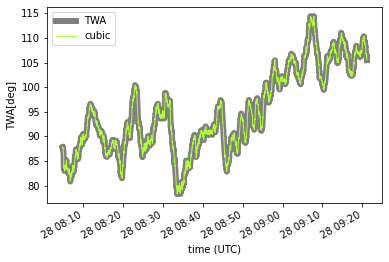

In [106]:
axes = twa_df.plot(x='_time',y='_value', label='TWA', color='grey', linewidth=6)
twa_df_s.plot(ax=axes, x='_time',y='_value', label='cubic', color='greenyellow', linewidth=1 )
plt.ylabel('TWA[deg]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()

## Performance variation analysis

In this example we are not going to make a full 360 degree circle observation area for wind angles since the range is smaller and we would not be able to use the entire real estate area. We probably will have many points to plot. From the above plots:

In [107]:
twa_min_theta = 70
twa_max_theta = 120

In [108]:
twa_min_theta_rad = math.radians(twa_min_theta)
twa_max_theta_rad = math.radians(twa_max_theta)

Speed values we know, too:

stw_min = 2.0
stw_max = 6.0

tws_min = 7/0
tws_max = 12.0

### Reference Polar Data

Your boat's polar in CSV file (not .pol)

In [109]:
pol_df = pd.read_csv("ref_polar.csv", sep=',')

#### Subroutine returning polar speed

This routine `def getpolspeed( pol_df, twa, tws )` has been developed and discussed in [1_TWA_TWS_STW_from_InfluxDBv2_calc_perf.ipynb](1_TWA_TWS_STW_from_InfluxDBv2_calc_perf.ipynb). It expects and is using the provided example polar file where the TWA column has header `TWA/TWS` (mandatory, used in selecting that column) and all other columns the respective TWS values.

In [110]:
def getpolspeed( pol_df, twa, tws ) :
    # print('twa: ', twa, 'tws: ', tws)
    twa_coldf = pol_df['TWA/TWS']
    lowertws_coldf = None
    lowertws = None
    uppertws_coldf = None
    uppertws = None

    for column_name, item in pol_df.iteritems():
        try:
            pol_tws = float(column_name)
            # print( pol_tws )
            if tws >= pol_tws :
                lowertws_coldf = item
                lowertws = pol_tws
            else :
                if pol_tws >= tws :
                    uppertws_coldf = item
                    uppertws = pol_tws
                    break
        except ValueError:
                # float() failure on the first column TWA/TWS
            	continue

    # print('lowertws: ', lowertws, ' type df: ', type(lowertws_coldf))
    # print('uppertws: ', uppertws, ' type df: ', type(uppertws_coldf))

    null_stw      = None
    lowertwa      = None
    uppertwa      = None
    lwrtwa_lwrtws = null_stw
    uprtwa_lwrtws = null_stw
    lwrtwa_uprtws = null_stw
    uprtwa_uprtws = null_stw
    
    for column_name, item in lowertws_coldf.iteritems():
        pol_twa = float(twa_coldf[column_name])
        # print( pol_twa )
        if twa >= pol_twa :
            lwrtwa_lwrtws = item
            lowertwa = pol_twa;
            # print('lowertwa: ', lowertwa, ' lwrtwa_lwrtws: ', lwrtwa_lwrtws)
        else :
            if pol_twa >= twa :
                if type(uprtwa_lwrtws) is type(null_stw) :
                    uprtwa_lwrtws = item
                    uppertwa = pol_twa;
                    # print('uppertwa: ', uppertwa, ' uprtwa_lwrtws: ', \
                    #       uprtwa_lwrtws)
                    break

    for column_name, item in uppertws_coldf.iteritems():
        pol_twa = float(twa_coldf[column_name])
        # print(pol_twa)
        if twa >= pol_twa :
            lwrtwa_uprtws = item
            # print('lwrtwa_uprtws: ', lwrtwa_uprtws)
        if pol_twa >= twa :
            if type(uprtwa_uprtws) is type(null_stw) :
                uprtwa_uprtws = item
                # print('uprtwa_uprtws: ', uprtwa_uprtws)
                break

    # Here we have the "square" of values in which the extrapolated value is located:

    # print('lowertws: ', lowertws)
    # print('lowertwa: ', lowertwa)
    # print('uppertws: ', uppertws)
    # print('uppertwa: ', uppertwa)
    # print('lwrtwa_lwrtws: ', lwrtwa_lwrtws)
    # print('uprtwa_lwrtws: ', uprtwa_lwrtws)
    # print('lwrtwa_uprtws: ', lwrtwa_uprtws)
    # print('uprtwa_uprtws: ', uprtwa_uprtws)

    # Consider the result being on a 3D plane with four corners, all inequal height.
    # There will be a point on that plane, the height of which is the estimated
    # polar speed for that point:

    # lwrtwa_lwrtws (x)--+-------(x) lwrtwa_uprtws
    #                |   |        |
    #                |   |        |
    #                +--(?)-------+
    #                |   |        |
    # uprtwa_lwrtws (x)--+-------(x) uprtwa_uprtws

    # Taking upper left corner as origin, we will calculate the point's
    # projected elevations.

    # **NOTE**: We can have planes which are sliding down (negative elevations),
    # especially when the wind speed is getting higher and the polar takes average
    # of different sail sets.

    lwrtwa_lwrtws_orig = 0.0
    lwrtwa_uprtws_elev = lwrtwa_uprtws - lwrtwa_lwrtws
    # print('lwrtwa_uprtws_elev: ', lwrtwa_uprtws_elev)
    uprtwa_lwrtws_elev = uprtwa_lwrtws - lwrtwa_lwrtws
    # print('uprtwa_lwrtws_elev: ', uprtwa_lwrtws_elev)
    uprtwa_uprtws_elev = uprtwa_uprtws - lwrtwa_lwrtws
    # print('uprtwa_uprtws_elev: ', uprtwa_uprtws_elev)

    #                    0.0 (x)--+-------(x) 0.2 lwrtwa_uprtws_elev
    #                         |   |        |
    #                         |   |        |
    #                         +--(?)-------+
    #                         |   |        |
    # uprtwa_lwrtws_elev 0.5 (x)--+-------(x) 0.8 uprtwa_uprtws_elev

    tws_ratio = (test_tws - lowertws)/(uppertws - lowertws)
    # print('tws_ratio: ', tws_ratio)

    twa_ratio = (test_twa - lowertwa)/(uppertwa - lowertwa)
    # print('twa_ratio: ', twa_ratio)

    y_lwrtws = twa_ratio * uprtwa_lwrtws_elev
    # print('y_lwrtws: ', y_lwrtws)

    y_uprtws = lwrtwa_uprtws_elev + (twa_ratio * (uprtwa_uprtws_elev - lwrtwa_uprtws_elev))
    # c('y_uprtws: ', y_uprtws)

    x_lwrtws = tws_ratio * lwrtwa_uprtws_elev
    # print('x_lwrtws: ', x_lwrtws)

    x_uprtws = uprtwa_lwrtws_elev + (tws_ratio * (uprtwa_uprtws_elev - uprtwa_lwrtws_elev))
    # print('x_uprtws: ', x_uprtws)

    #                             0.09 x_lwrtws
    #                    0.0 (x)--+-------(x) 0.2 lwrtwa_uprtws_elev
    #                         |   |        |
    #                         |   |        |
    #           y_lwrtws 0.22 +--(?)-------+ 0.46 y_uprtws
    #                         |   |        |
    # uprtwa_lwrtws_elev 0.5 (x)--+-------(x) 0.8 uprtwa_uprtws_elev
    #                             0.64 x_uprtws

    ##### Result

    x_res = x_lwrtws + (x_uprtws - x_lwrtws) * twa_ratio
    # print('x_res: ', x_res)
    # print('result: ', (lwrtwa_lwrtws + x_res))

    ##### Verification

    y_res = y_lwrtws + (y_uprtws - y_lwrtws) * tws_ratio
    # print('y_res: ', y_res)
    if round(y_res,2) != round(x_res,2) :
        printf('WARNING: polar explaration function verification fails: ', x_res, y_res)

    return round((lwrtwa_lwrtws + x_res),2)

##### Test polar speed subroutine

In [111]:
test_twa = 37.2
test_tws = 10.9

In [112]:
test_pol_speed = getpolspeed( pol_df, test_twa, test_tws )
print('test_pol_speed: ', test_pol_speed)
if round(test_pol_speed,2) != 3.83 :
    print('getpolspeed test FAIL: was expecting 3.83 with the test polar file')

test_pol_speed:  3.83


In [113]:
test_twa = 60.24671838095237 
test_tws = 6.030811476190476

In [114]:
test_pol_speed = getpolspeed( pol_df, test_twa, test_tws )
print('test_pol_speed: ', test_pol_speed)
if round(test_pol_speed,2) != 5.01 :
    print('getpolspeed test FAIL: was expecting 5.01 with the test polar file')

test_pol_speed:  5.01


### Determine time range

Index the dataframes with the time (with one second interval now):

In [115]:
tmin = stw_df_s.min()._time

In [116]:
tmin

Timestamp('2018-09-28 08:04:48+0000', tz='tzutc()')

In [117]:
tmax = stw_df_s.max()._time

In [118]:
tmax

Timestamp('2018-09-28 09:21:09+0000', tz='tzutc()')

In [119]:
stw_df_s.set_index('_time', inplace=True)

In [120]:
tws_df_s.set_index('_time',inplace=True)

In [121]:
twa_df_s.set_index('_time',inplace=True)

### Combine data sets

In [122]:
s_columns = ['_time','tws', 'twa', 'twar','stw','pols','perf','pdelta']

In [123]:
com_df_s = pd.DataFrame(columns = s_columns, index=['_time'])

In [124]:
com_df_s.is_copy = False

In [125]:
com_df_s

,_time,tws,twa,twar,stw,pols,perf,pdelta
_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
sloopval = tmin

In [127]:
stw_df_s[stw_df_s.index == sloopval].index

DatetimeIndex(['2018-09-28 08:04:48+00:00'], dtype='datetime64[ns, tzutc()]', name='_time', freq=None)

In [128]:
stw_df_s[stw_df_s.index == sloopval]._value[0]

4.961811858893803

In [129]:
s_delta = pd.Timedelta(1,unit='seconds')

In [130]:
s_delta

Timedelta('0 days 00:00:01')

In [131]:
while sloopval <= tmax:
    twa  = twa_df_s[twa_df_s.index == sloopval]._value[0]
    twar = math.radians(twa)
    tws  = tws_df_s[twa_df_s.index == sloopval]._value[0]
    stw  = stw_df_s[stw_df_s.index == sloopval]._value[0]
    pols = getpolspeed( pol_df, twa, tws )
    perf = stw / pols * 100
    pdelta = perf - 100
    com_df_s.loc[len(com_df_s.index)] = [ sloopval, tws, twa, twar, \
                                         stw, pols, perf, pdelta ]
    sloopval = sloopval + s_delta

In [132]:
com_df_s.dropna()

,_time,tws,twa,twar,stw,pols,perf,pdelta
1,2018-09-28 08:04:48+00:00,9.583894,87.618925,1.529239,4.961812,6.05,82.013419,-17.986581
2,2018-09-28 08:04:49+00:00,9.579724,87.582874,1.528610,4.969339,6.05,82.137833,-17.862167
3,2018-09-28 08:04:50+00:00,9.572282,87.662152,1.529993,4.988014,6.05,82.446514,-17.553486
4,2018-09-28 08:04:51+00:00,9.540858,87.889942,1.533969,5.005118,6.05,82.729227,-17.270773
5,2018-09-28 08:04:52+00:00,9.485614,87.802333,1.532440,5.011495,6.05,82.834636,-17.165364
...,...,...,...,...,...,...,...,...
4578,2018-09-28 09:21:05+00:00,9.173441,106.464346,1.858153,4.024819,4.24,94.924967,-5.075033
4579,2018-09-28 09:21:06+00:00,9.165927,106.475975,1.858356,4.028925,4.24,95.021821,-4.978179
4580,2018-09-28 09:21:07+00:00,9.146408,106.313460,1.855520,4.031996,4.24,95.094242,-4.905758
4581,2018-09-28 09:21:08+00:00,9.109228,105.922157,1.848690,4.025957,4.24,94.951814,-5.048186


Pivot table would be needed if we would continue with a pure matplotlib polar plot. I keep it here for the memory of many failed attempts to bring in similar informative layout than in below `seaborn` library plots!

In [133]:
# com_df_s_t = pd.pivot_table(com_df_s, columns=['twar'], values=['pdelta'])
# com_df_s_t

### Analyze

#### Scatter plot

It is to be noted that we use here the very informative`seaborn` library, not directly `matplot` as above this line.

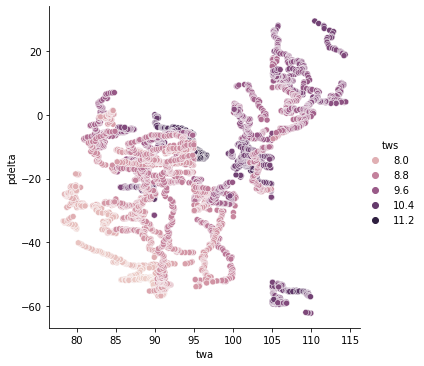

In [134]:
sns.relplot(x="twa", y="pdelta", hue="tws", data=com_df_s);

#### Polar scatter plot

Polar plots in matplot are complicated since one needs to use numpy to build the polar in radians and scale the values alike. Life is easier with `seaborn`. Above, we have set (visually, from graphs) some zoom values to better use the real estate area of the plot: `twa_min_theta` and `twa_max_theta`.

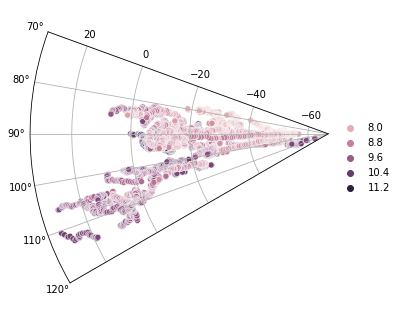

In [135]:
fg = sns.FacetGrid(com_df_s, subplot_kws=dict(projection='polar'), height=5, \
                   sharex=False, sharey=False, despine=False, \
                   legend_out=True )
fg.map_dataframe(sns.scatterplot, x='twar', y='pdelta', hue='tws')
fg.add_legend()
plt.gca().set_thetamin(twa_min_theta)
plt.gca().set_thetamax(twa_max_theta)
plt.gca().set_theta_zero_location("N")
plt.show()

#### Interpretation

From the above scatter distribution and comparing that to the timed plots of TWA/TWS we can conclude that we were not sailing very aggressively in the beginning when beating, there is no particular conclusion to make from that, it was just bad sailing... After the wind shift, we were awaken: the polar file and our performance against it are matching. On broad reach we did not do any particular change, just normal adjustments. However, the polar performance was augmented above the polar estimated. The polar, in this case could be pumped up in region of 100 - 120 degree and wind speed 8 - 12 knots by 15 or 20 percent.

## Conclusion

We have demonstrated that regarding the database queries using Flux the overall efficiency of the process, including all the steps that will follow the query is better if the data parameters are requested individually and collected for processsing in individual 2D Pandas DataFrames with only timestamp and the value columns.

The paper points out that the data rows in Pandas DataFrames must be synchronized in time for reliably compare the values collected in long period of time but coming from instruments which are asynchronously collecting data without common clock and with undeterministic data rates.

We have defined a method implementing point interpolation in synchronized time tick using cubic spline function to align the collected data in one second interval.

Two methods of cubic spline function implementations were tested. The GEKKO library method for statistical calculations is promising since one can feed into it an the requested timestamps and it interpolates the values. Unfortunately, it is an on-line service which is doing the calculation remotely - by default - and the service failed to find a solution to the large number of points our data contains. It is possible to compile and install a local server but this was not tested.

Instead, the SciPy cubic spline function was used through standard functions of Pandas DataFrame. The method proved to be efficient and accurate.

The resulting, synchronized and re-composed 2D Pandas DataFrame was used by demonstrating the creation of scattered plots for performance data against the polar profile of the boat. For this, `seaborn` statistical plot library was used on top the `matplot` library.

It produces highly informative data plots, allowing us to come to the final conclusion: we were sailing pretty badly that day!